# **Flipkart Classification Project**    -

## **Github** -

https://github.com/aniket010011/Intern-Projects

### **Problem Statement and Description**    -

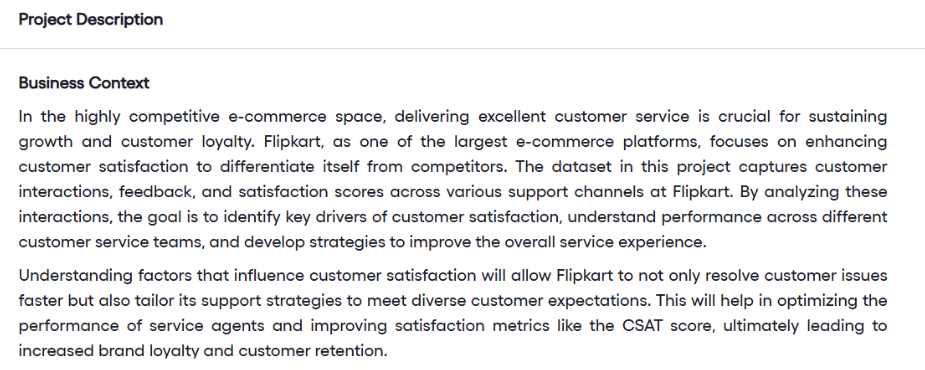

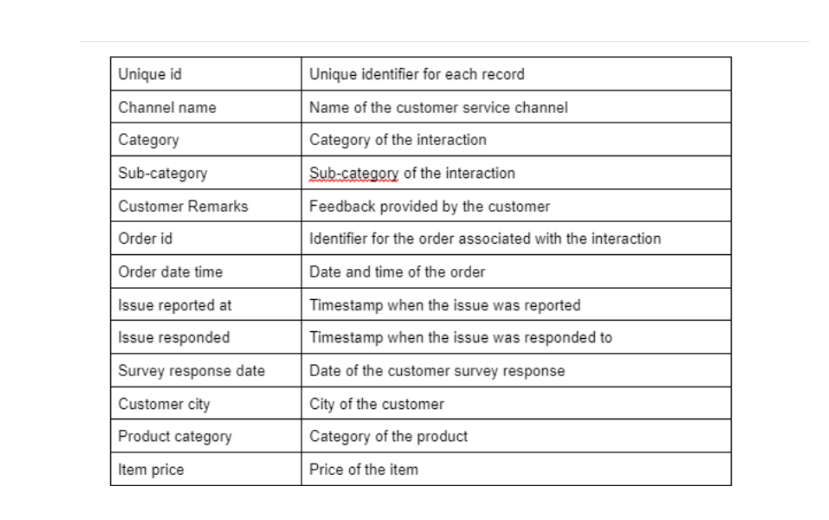

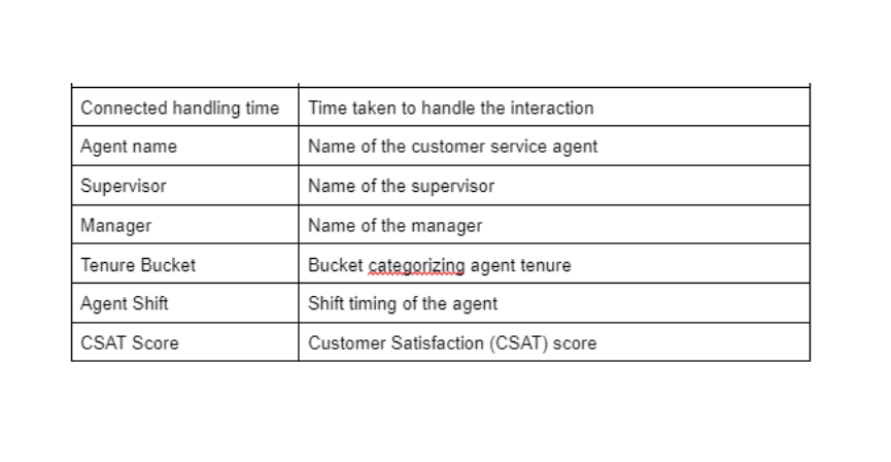

### **AIM**

*   Find the key contributing columns affecting CSAT score
*   Find the distribution and relation between the key columns and CSAT score
*   Help client improve performance of workers to attain better CSAT score

### **Solution**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from collections import Counter
from imblearn.combine import SMOTETomek
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score, fbeta_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_data = '/content/Customer_support_data.csv'
df_data = pd.read_csv(file_data)

In [3]:
df_data.shape


(85907, 20)

In [4]:
df_data.columns

Index(['Unique id', 'channel_name', 'category', 'Sub-category',
       'Customer Remarks', 'Order_id', 'order_date_time', 'Issue_reported at',
       'issue_responded', 'Survey_response_Date', 'Customer_City',
       'Product_category', 'Item_price', 'connected_handling_time',
       'Agent_name', 'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift',
       'CSAT Score'],
      dtype='object')

In [5]:
len(df_data.columns)

20

In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unique id                85907 non-null  object 
 1   channel_name             85907 non-null  object 
 2   category                 85907 non-null  object 
 3   Sub-category             85907 non-null  object 
 4   Customer Remarks         28742 non-null  object 
 5   Order_id                 67675 non-null  object 
 6   order_date_time          17214 non-null  object 
 7   Issue_reported at        85907 non-null  object 
 8   issue_responded          85907 non-null  object 
 9   Survey_response_Date     85907 non-null  object 
 10  Customer_City            17079 non-null  object 
 11  Product_category         17196 non-null  object 
 12  Item_price               17206 non-null  float64
 13  connected_handling_time  242 non-null    float64
 14  Agent_name            

In [7]:
df_data.describe()

,Item_price,connected_handling_time,CSAT Score
count,17206.000000,242.000000,85907.000000
mean,5660.774846,462.400826,4.242157
std,12825.728411,246.295037,1.378903
min,0.000000,0.000000,1.000000
25%,392.000000,293.000000,4.000000
50%,979.000000,427.000000,5.000000
75%,2699.750000,592.250000,5.000000
max,164999.000000,1986.000000,5.000000


In [8]:
def missing_values_summary(df_data: pd.DataFrame) -> pd.Series:

    missing_counts = df_data.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0]  # keep only columns with missing values
    return missing_counts.sort_values(ascending=False)


In [9]:
missing_values_summary(df_data)

,0
connected_handling_time,85665
Customer_City,68828
Product_category,68711
Item_price,68701
order_date_time,68693
Customer Remarks,57165
Order_id,18232


Eliminating columns that have high missing values and unlikely to contribute to CSAT score

In [10]:
df_data.drop(['Unique id', 'Order_id', 'order_date_time', 'Survey_response_Date', 'connected_handling_time', 'Customer_City', 'Product_category', 'Item_price'], axis=1, inplace=True)
df_data.head(5)

,channel_name,category,Sub-category,Customer Remarks,Issue_reported at,issue_responded,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score
0,Outcall,Product Queries,Life Insurance,NaN,01/08/2023 11:13,01/08/2023 11:47,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,Outcall,Product Queries,Product Specific Information,NaN,01/08/2023 12:52,01/08/2023 12:54,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5
2,Inbound,Order Related,Installation/demo,NaN,01/08/2023 20:16,01/08/2023 20:38,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5
3,Inbound,Returns,Reverse Pickup Enquiry,NaN,01/08/2023 20:56,01/08/2023 21:16,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5
4,Inbound,Cancellation,Not Needed,NaN,01/08/2023 10:30,01/08/2023 10:32,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5


In [11]:
len(df_data.columns)

12

In [12]:
df_data.columns

Index(['channel_name', 'category', 'Sub-category', 'Customer Remarks',
       'Issue_reported at', 'issue_responded', 'Agent_name', 'Supervisor',
       'Manager', 'Tenure Bucket', 'Agent Shift', 'CSAT Score'],
      dtype='object')

In [13]:
duplicates = df_data.duplicated().sum().tolist()
duplicates

9

In [14]:
df_data[df_data.duplicated()]

,channel_name,category,Sub-category,Customer Remarks,Issue_reported at,issue_responded,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score
9242,Inbound,Order Related,Installation/demo,NaN,04/08/2023 09:54,04/08/2023 10:00,Kathryn Vasquez,Noah Patel,Michael Lee,>90,Morning,5
12002,Inbound,Returns,Reverse Pickup Enquiry,NaN,05/08/2023 09:15,05/08/2023 09:26,Anthony Booth,William Park,John Smith,31-60,Morning,5
16899,Inbound,Payments related,e-Gift Voucher,NaN,07/08/2023 22:05,07/08/2023 22:23,Lee Allen PhD,Elijah Yamaguchi,John Smith,>90,Evening,5
53253,Outcall,Payments related,Payment related Queries,NaN,20/08/2023 10:21,20/08/2023 10:26,Randy May,Emily Yamashita,William Kim,On Job Training,Evening,5
58444,Outcall,Shopzilla Related,Shopzila Premium Related,NaN,22/08/2023 21:14,22/08/2023 21:17,Rebecca Walker,Logan Lee,Emily Chen,61-90,Evening,5
61792,Email,Returns,Reverse Pickup Enquiry,NaN,23/08/2023 10:56,23/08/2023 10:57,Joe Chapman,Sophia Chen,Jennifer Nguyen,On Job Training,Evening,5
77516,Email,Order Related,Unable to track,NaN,28/08/2023 18:30,28/08/2023 00:00,Mrs. Jennifer Stone,Dylan Kim,Michael Lee,>90,Morning,1
79734,Email,Returns,Reverse Pickup Enquiry,NaN,28/08/2023 12:30,29/08/2023 10:18,Janet Shea,Emma Park,Olivia Tan,>90,Morning,4
85501,Email,Order Related,Delayed,NaN,30/08/2023 11:03,31/08/2023 21:59,Jose Pruitt,Zoe Yamamoto,William Kim,On Job Training,Morning,1


In [15]:
df_data.shape

(85907, 12)

In [16]:
df_data=df_data.drop_duplicates().reset_index(drop=True)

In [17]:
df_data.shape

(85898, 12)

In [18]:
df_data.nunique()

,0
channel_name,3
category,12
Sub-category,57
Customer Remarks,18231
Issue_reported at,30923
issue_responded,30262
Agent_name,1371
Supervisor,40
Manager,6
Tenure Bucket,5


Creating lists of numerical and categorical columns

In [19]:
num_cols = df_data.select_dtypes(include=['number']).columns.tolist()
cat_cols = df_data.select_dtypes(include=['object', 'category']).columns.tolist()
print("Numerical features : ", num_cols)
print("Categorical features : ", cat_cols)

Numerical features :  ['CSAT Score']
Categorical features :  ['channel_name', 'category', 'Sub-category', 'Customer Remarks', 'Issue_reported at', 'issue_responded', 'Agent_name', 'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift']


Converting data in issue reported and issue responded columns into computable form in another column

In [20]:
df_data['Issue_reported at'] = pd.to_datetime(df_data['Issue_reported at'], errors="coerce")
df_data['issue_responded'] = pd.to_datetime(df_data['issue_responded'], errors="coerce")

# calculate resolution time
df_data['resolution_time'] = df_data['issue_responded'] - df_data['Issue_reported at']
df_data['resolution_time'] = df_data['resolution_time'].dt.total_seconds()
df_data.head(5)

,channel_name,category,Sub-category,Customer Remarks,Issue_reported at,issue_responded,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score,resolution_time
0,Outcall,Product Queries,Life Insurance,NaN,2023-01-08 11:13:00,2023-01-08 11:47:00,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5,2040.0
1,Outcall,Product Queries,Product Specific Information,NaN,2023-01-08 12:52:00,2023-01-08 12:54:00,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5,120.0
2,Inbound,Order Related,Installation/demo,NaN,2023-01-08 20:16:00,2023-01-08 20:38:00,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5,1320.0
3,Inbound,Returns,Reverse Pickup Enquiry,NaN,2023-01-08 20:56:00,2023-01-08 21:16:00,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5,1200.0
4,Inbound,Cancellation,Not Needed,NaN,2023-01-08 10:30:00,2023-01-08 10:32:00,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5,120.0


In [21]:
len(df_data.columns)


13

In [22]:
df_data.drop(['Issue_reported at', 'issue_responded'], axis=1, inplace=True)
len(df_data.columns)

11

In [23]:
df_data.head(5)

,channel_name,category,Sub-category,Customer Remarks,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score,resolution_time
0,Outcall,Product Queries,Life Insurance,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5,2040.0
1,Outcall,Product Queries,Product Specific Information,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5,120.0
2,Inbound,Order Related,Installation/demo,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5,1320.0
3,Inbound,Returns,Reverse Pickup Enquiry,NaN,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5,1200.0
4,Inbound,Cancellation,Not Needed,NaN,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5,120.0


Visualization and Observation

Plotting CSAT Score and Resolution Time

<Axes: xlabel='CSAT Score', ylabel='Count'>

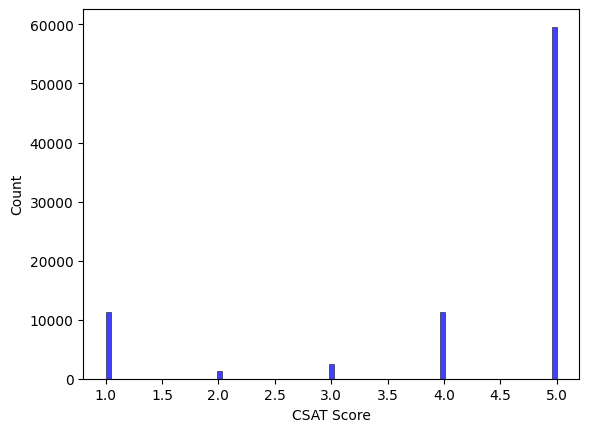

In [24]:
sns.histplot(x='CSAT Score', color='blue', data=df_data)

It is evident from the graph that 5 star scores form the majority class while every other score represents very few records and are in minority

<function matplotlib.pyplot.show(close=None, block=None)>

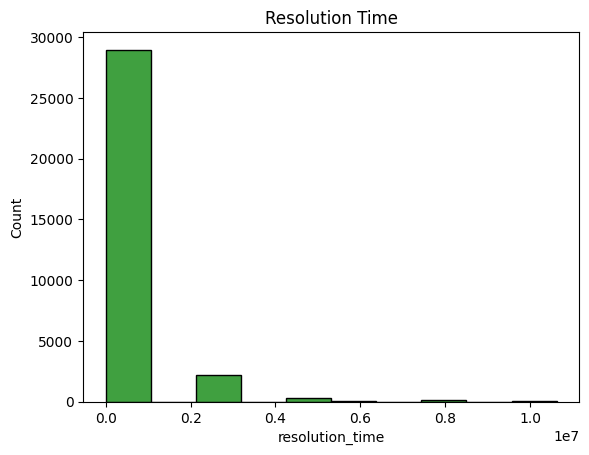

In [25]:
sns.histplot(x='resolution_time', color='green', data=df_data, bins=10, kde=False)
plt.title("Resolution Time")

plt.show

Channel based Distribution

<Axes: xlabel='channel_name', ylabel='Count'>

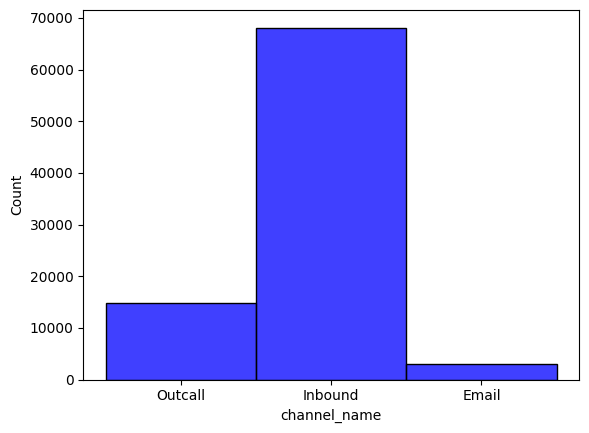

In [26]:
sns.histplot(x='channel_name', color='blue', data=df_data)

Majority of the records are from Inbound channel

Category based Distribution

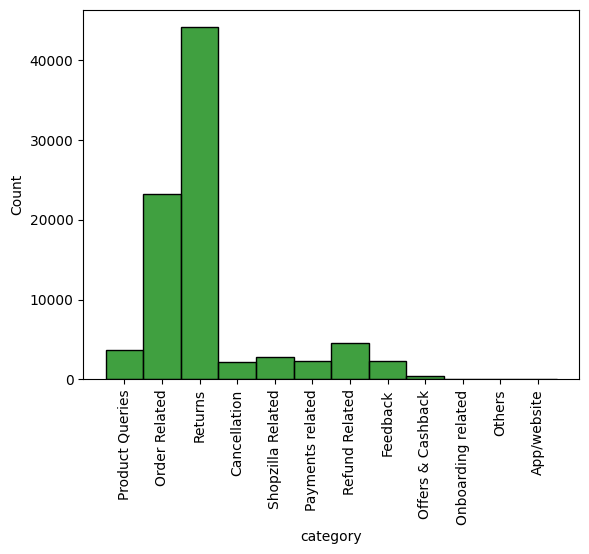

In [27]:
sns.histplot(x='category', color='green', data=df_data)
plt.xticks(rotation=90)
plt.show()

Bulk of the records are from Returns and Order Related tickets

Manager based Distribution

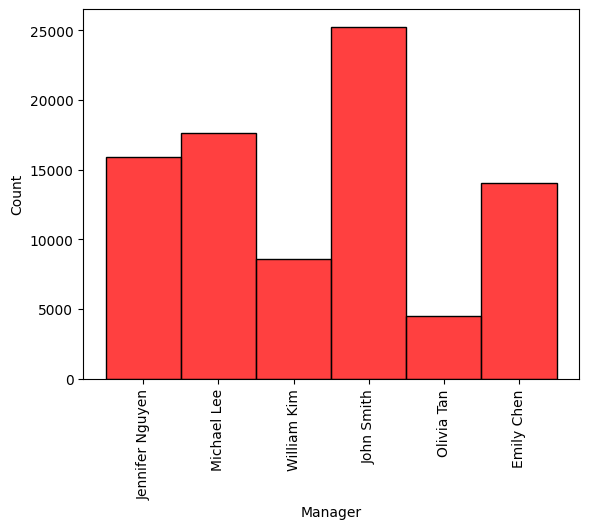

In [28]:
sns.histplot(x='Manager', color='red', data=df_data)
plt.xticks(rotation=90)
plt.show()

This graph shows the quantity of tickets handled by each Manager

Supervisor based Distribution

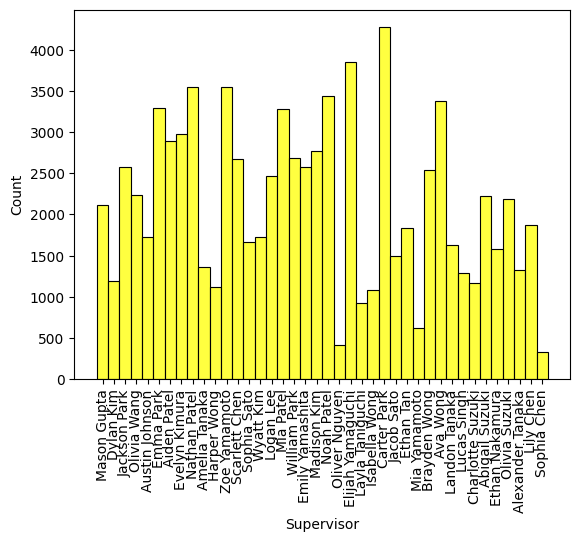

In [29]:
sns.histplot(x='Supervisor', color='yellow', data=df_data)
plt.xticks(rotation=90)
plt.show()

This graph shows the quantity of tickets handled by teams under each Supervisor

Resolution Time by CSAT score

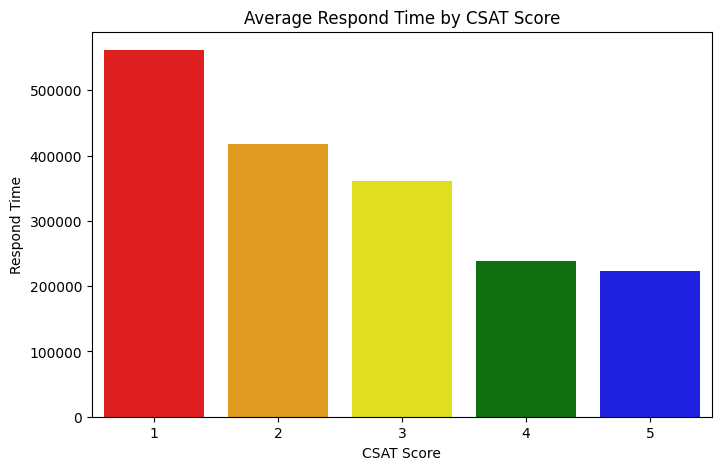

In [30]:
custom_palette = {
    '1': 'red',
    '2': 'orange',
    '3': 'yellow',
    '4': 'green',
    '5': 'blue'
}
plt.figure(figsize=(8, 5))
avg_respond_time = df_data.groupby('CSAT Score')['resolution_time'].mean().reset_index()
sns.barplot(x='CSAT Score', y='resolution_time', data=avg_respond_time, palette=custom_palette)
plt.xlabel('CSAT Score')
plt.ylabel('Respond Time')
plt.title("Average Respond Time by CSAT Score")
plt.show()

From the plot it is evident that shorter responses have led to higher CSAT scores

Channels by CSAT Score

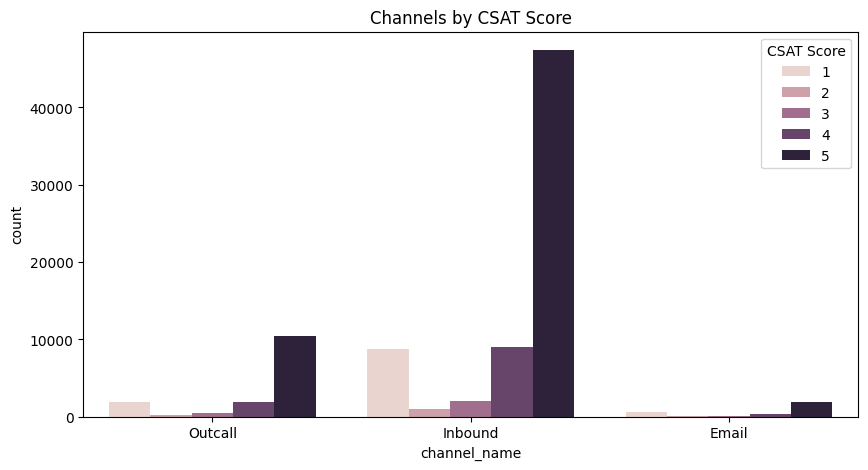

In [31]:
plt.figure(figsize=(10, 5))
sns.countplot(x='channel_name', hue='CSAT Score', data=df_data)
plt.title("Channels by CSAT Score")
plt.show()

The variation of CSAT Score is proportional across all 3 channels

Managers by CSAT Score

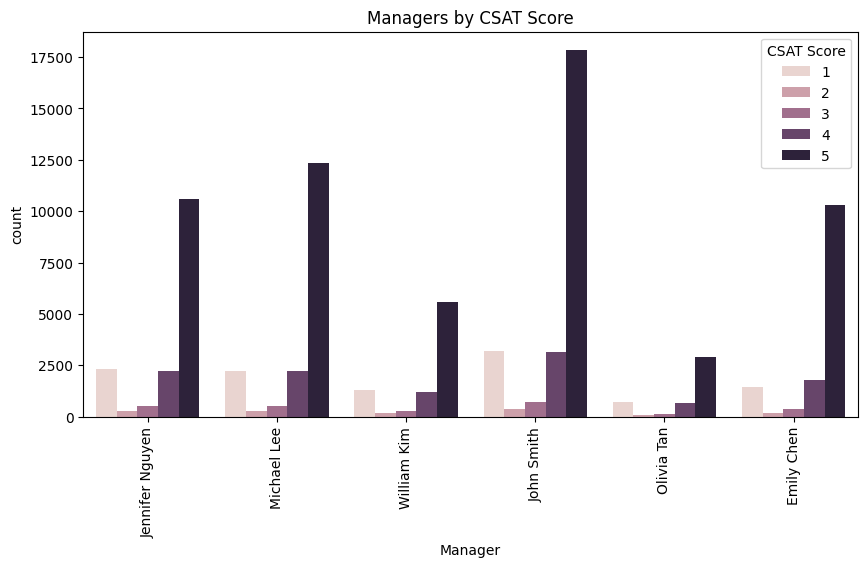

In [32]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Manager', hue='CSAT Score', data=df_data)
plt.title("Managers by CSAT Score")
plt.xticks(rotation=90)
plt.show()

From this graph it can be determined which managers performed well and which managers need to improve by observing the count of maximum CSAT scores achieved by each manager

Supervisor by CSAT Score

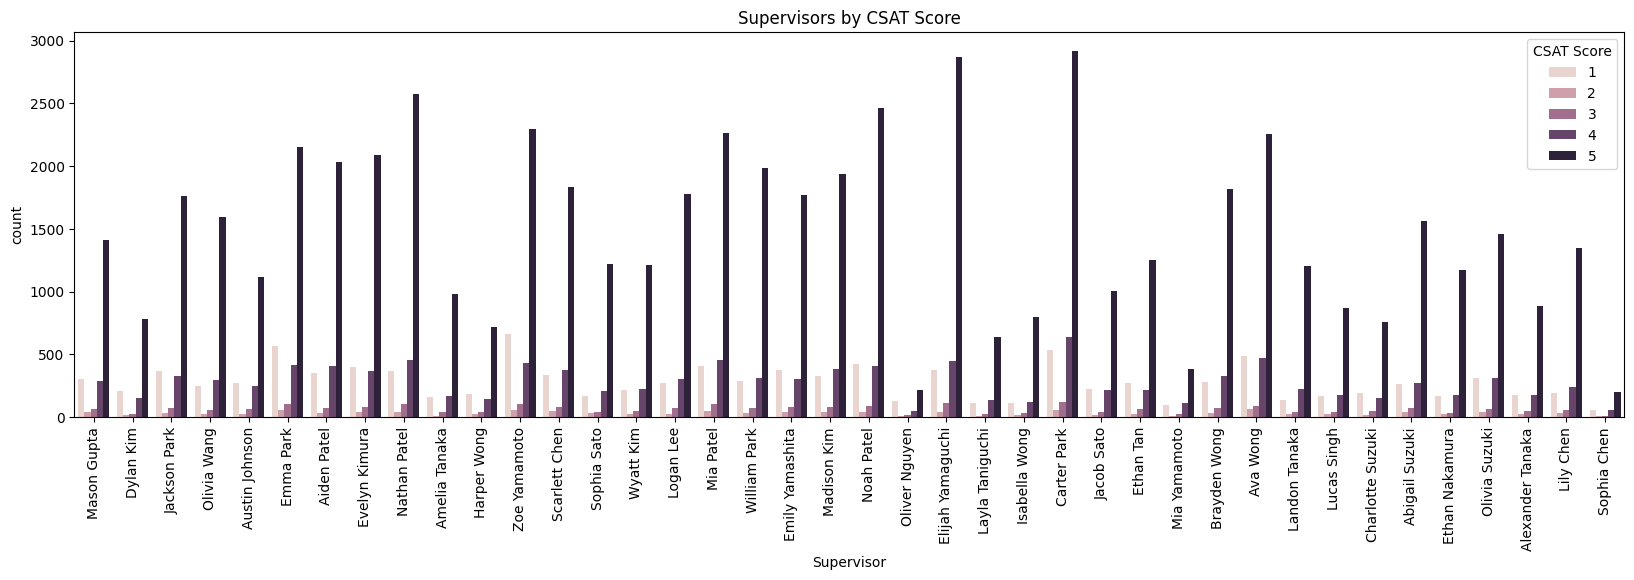

In [33]:
plt.figure(figsize=(20, 5))
sns.countplot(x='Supervisor', hue='CSAT Score', data=df_data)
plt.title("Supervisors by CSAT Score")
plt.xticks(rotation=90)
plt.show()

Similar to the graph for Managers the amount of maximum CSAT Score achieved is determining which supervisors need their teams to improve

Finding out Customer sentiment towards resolutions with the help of NLTK

In [34]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [35]:
def classify_sentiments(df: pd.DataFrame, text_col: str) -> pd.DataFrame:

    sia = SentimentIntensityAnalyzer()

    def get_sentiment(text):
        if pd.isnull(text) or str(text).strip() == "":
            return "Missing"
        score = sia.polarity_scores(str(text))["compound"]
        if score >= 0.05:
            return "Positive"
        elif score <= -0.05:
            return "Negative"
        else:
            return "Neutral"  # keep neutral separate (optional)

    # create a copy so original df isn’t modified
    new_df = df.copy()
    new_df["Sentiment"] = new_df[text_col].apply(get_sentiment)
    return new_df

In [36]:
df_data = classify_sentiments(df_data, "Customer Remarks")
df_data.head(10)

,channel_name,category,Sub-category,Customer Remarks,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score,resolution_time,Sentiment
0,Outcall,Product Queries,Life Insurance,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5,2040.0,Missing
1,Outcall,Product Queries,Product Specific Information,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5,120.0,Missing
2,Inbound,Order Related,Installation/demo,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5,1320.0,Missing
3,Inbound,Returns,Reverse Pickup Enquiry,NaN,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5,1200.0,Missing
4,Inbound,Cancellation,Not Needed,NaN,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5,120.0,Missing
5,Email,Returns,Fraudulent User,NaN,Desiree Newton,Emma Park,John Smith,0-30,Morning,5,12360.0,Missing
6,Outcall,Product Queries,Product Specific Information,NaN,Shannon Hicks,Aiden Patel,Olivia Tan,>90,Morning,5,30060.0,Missing
7,Inbound,Returns,Exchange / Replacement,Very good,Laura Smith,Evelyn Kimura,Jennifer Nguyen,On Job Training,Evening,5,360.0,Positive
8,Inbound,Returns,Missing,Shopzilla app and it's all coustomer care serv...,David Smith,Nathan Patel,John Smith,>90,Split,5,240.0,Positive
9,Inbound,Shopzilla Related,General Enquiry,NaN,Tabitha Ayala,Amelia Tanaka,Michael Lee,31-60,Evening,5,300.0,Missing


In [37]:
df_data = df_data.drop(['Customer Remarks'], axis=1)
df_data.head(10)

,channel_name,category,Sub-category,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score,resolution_time,Sentiment
0,Outcall,Product Queries,Life Insurance,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5,2040.0,Missing
1,Outcall,Product Queries,Product Specific Information,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5,120.0,Missing
2,Inbound,Order Related,Installation/demo,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5,1320.0,Missing
3,Inbound,Returns,Reverse Pickup Enquiry,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5,1200.0,Missing
4,Inbound,Cancellation,Not Needed,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5,120.0,Missing
5,Email,Returns,Fraudulent User,Desiree Newton,Emma Park,John Smith,0-30,Morning,5,12360.0,Missing
6,Outcall,Product Queries,Product Specific Information,Shannon Hicks,Aiden Patel,Olivia Tan,>90,Morning,5,30060.0,Missing
7,Inbound,Returns,Exchange / Replacement,Laura Smith,Evelyn Kimura,Jennifer Nguyen,On Job Training,Evening,5,360.0,Positive
8,Inbound,Returns,Missing,David Smith,Nathan Patel,John Smith,>90,Split,5,240.0,Positive
9,Inbound,Shopzilla Related,General Enquiry,Tabitha Ayala,Amelia Tanaka,Michael Lee,31-60,Evening,5,300.0,Missing


In [38]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85898 entries, 0 to 85897
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   channel_name     85898 non-null  object 
 1   category         85898 non-null  object 
 2   Sub-category     85898 non-null  object 
 3   Agent_name       85898 non-null  object 
 4   Supervisor       85898 non-null  object 
 5   Manager          85898 non-null  object 
 6   Tenure Bucket    85898 non-null  object 
 7   Agent Shift      85898 non-null  object 
 8   CSAT Score       85898 non-null  int64  
 9   resolution_time  31630 non-null  float64
 10  Sentiment        85898 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 7.2+ MB


Train Test Split

In [39]:
X = df_data.drop('CSAT Score', axis=1)
y = df_data['CSAT Score']

In [40]:
X.shape

(85898, 10)

In [41]:
y.shape

(85898,)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2, stratify = y)

In [43]:
print(X_train.shape)
print(X_test.shape)

(68718, 10)
(17180, 10)


In [44]:
num_columns = [feature for feature in X.columns if X[feature].dtype != 'O']
cat_columns = [feature for feature in X.columns if X[feature].dtype == 'O']

In [45]:
num_pipe = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

In [46]:
cat_pipe = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'constant')),
    ('onehot_encoder', OrdinalEncoder())
])

In [47]:
column_tf = ColumnTransformer([
    ('num', num_pipe, num_columns),
    ('cat', cat_pipe, cat_columns),
],
    remainder = 'drop',
)

In [48]:
final_pipe = Pipeline(steps = [
    ('column_transformer', column_tf), ('classifier', LogisticRegression())
])

In [49]:
final_pipe.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['resolution_time']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['channel_name', 'category',
                                                   'Sub-category', 'Agent_name',
                                                   'Supervisor', 'Manager',
                                                   'Tenure Bucket',
                                                   'Agent Shift',
                                                   'Sentiment'])])),
                ('classifier', LogisticRegression())])

In [50]:
final_pipe.feature_names_in_

array(['channel_name', 'category', 'Sub-category', 'Agent_name',
       'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift',
       'resolution_time', 'Sentiment'], dtype=object)

Models and their performance

Logistic Regression

In [51]:
final_pipe = Pipeline(steps = [
    ('column_transformer', column_tf), ('classifier', LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial', class_weight='balanced'))
])
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 60)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3, 4, 5])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 60)

Logistic Regression
              precision    recall  f1-score   support

           1       0.21      0.25      0.23      2246
           2       0.02      0.19      0.03       256
           3       0.03      0.07      0.05       512
           4       0.15      0.46      0.23      2244
           5       0.74      0.25      0.37     11922

    accuracy                           0.27     17180
   macro avg       0.23      0.24      0.18     17180
weighted avg       0.56      0.27      0.32     17180

Accuracy: 0.2728754365541327
____________________________________________________________
ROC-AUC Score (macro, OVR): 0.5281639141260935
____________________________________________________________


Random Forest Classifier

In [52]:
final_pipe = Pipeline(steps = [
    ('column_transformer', column_tf), ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)

print("Random Forest")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 60)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3, 4, 5])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 60)

Random Forest
              precision    recall  f1-score   support

           1       0.35      0.27      0.31      2246
           2       0.02      0.02      0.02       256
           3       0.03      0.03      0.03       512
           4       0.15      0.10      0.12      2244
           5       0.73      0.80      0.76     11922

    accuracy                           0.61     17180
   macro avg       0.26      0.25      0.25     17180
weighted avg       0.57      0.61      0.59     17180

Accuracy: 0.6073923166472642
____________________________________________________________
ROC-AUC Score (macro, OVR): 0.5349012790872267
____________________________________________________________


LightGBM Classifier

In [53]:
final_pipe = Pipeline(steps = [
    ('column_transformer', column_tf), ('classifier', lgbm.LGBMClassifier(boosting_type = 'gbdt', learning_rate = 0.05, n_estimators= 300, max_depth = -1, num_leaves = 15, class_weight = {1:1}))
])
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)

print("LightGBMClassifier")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("_" * 60)

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_bin = label_binarize(y_pred, classes=[1, 2, 3, 4, 5])
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr', average='macro')
print("ROC-AUC Score (macro, OVR):", roc_auc)
print("_" * 60)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 68718, number of used features: 10
[LightGBM] [Info] Start training from score -2.034789
[LightGBM] [Info] Start training from score -4.203369
[LightGBM] [Info] Start training from score -3.514125
[LightGBM] [Info] Start training from score -2.035680
[LightGBM] [Info] Start training from score -0.365310
LightGBMClassifier
              precision    recall  f1-score   support

           1       0.62      0.26      0.36      2246
           2       0.00      0.00      0.00       256
           3       0.00      0.00      0.00       512
           4       0.00      0.00      0.00      2244
           5       0.72      0.98      0.83     11922

    accuracy                     

## **Result**

As can be seen from the performance of the three models used, LightGBM Classifier can be seen to provide the best results with an accuracy score over 71%